In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras import optimizers
from keras import models,layers
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from zipfile import ZipFile
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
classes = ["cloudy","rain","shine","sunrise"]
sets = ["train","validation"]
zip_path = "/content/drive/MyDrive/Datasets/weather_dataset.zip"
dataset_path = "/content/weather_dataset"
weights_path = "/content/drive/MyDrive/checkpoints/exa2/weights.h5"

In [5]:
with ZipFile(zip_path, 'r') as zip: 
    zip.extractall(dataset_path)

In [6]:
# Creating folders
for s in sets:
    temp_path = os.path.join(dataset_path,s)
    os.mkdir(temp_path)
    for c in classes:
        os.mkdir(os.path.join(temp_path,c))

# Moving files to folders and shuring that images are not corrupted
for s in sets:
  for f in os.listdir(os.path.join(dataset_path,"dataset2")):
    for c in classes:
      if(c in f):
        from_path = os.path.join(dataset_path,"dataset2",f)
        to_path = os.path.join(dataset_path,s,c,f)
        if(len(os.listdir(os.path.join(dataset_path,s,c))) < 150):
          try:
            img = Image.open(from_path)
            img.verify()
            os.rename(from_path,to_path)
          except (IOError, SyntaxError) as e:
            print("IMAGE CORRUPTED:",from_path)
            continue

In [13]:
#Using ImageDataGenerator to read images from directories
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        os.path.join(dataset_path,"train"), 
        color_mode="rgb",
        batch_size=1,
        target_size=(224, 224),
        shuffle=True)

validation_generator = test_datagen.flow_from_directory(
        os.path.join(dataset_path,"validation"),
        color_mode="rgb",
        batch_size=1,
        target_size=(224, 224),
        shuffle=False) # FALSE

Found 600 images belonging to 4 classes.
Found 468 images belonging to 4 classes.


In [8]:
# Creating Callback to save model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/checkpoints/exa2/weights.h5",
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_acc', 
                                                 mode='max',
                                                 verbose=1)

# Trasnfer learning from Xception
conv_base = VGG16(include_top=False,
                      weights="imagenet",
                      input_shape=(224, 224, 3))

# Freezing important weights.
for layer in conv_base.layers:
    if layer.name[:6] == 'block5': 
      layer.trainable = True
    else:
      layer.trainable = False

# Defining model
model = models.Sequential()
model.add(conv_base)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization()) 
model.add(layers.Flatten())
model.add(layers.Dense(4, activation='softmax'))

# Compiling model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc']) #'acc' -> accuracy -> precisión

58892288/58889256 [==============================] - 1s 0us/step


In [9]:
#Training and validation stages
history = model.fit(train_generator,
                    steps_per_epoch=50, 
                    epochs=400,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[cp_callback])

Epoch 1/400
50/50 [==============================] - 8s 28ms/step - loss: 1.5785 - acc: 0.3963 - val_loss: 1.2308 - val_acc: 0.4400

Epoch 00001: val_acc improved from -inf to 0.44000, saving model to /content/drive/MyDrive/checkpoints/exa2/weights.h5
Epoch 2/400
50/50 [==============================] - 1s 24ms/step - loss: 1.0122 - acc: 0.5194 - val_loss: 1.2609 - val_acc: 0.4200

Epoch 00002: val_acc did not improve from 0.44000
Epoch 3/400
50/50 [==============================] - 1s 24ms/step - loss: 0.8573 - acc: 0.6161 - val_loss: 0.7772 - val_acc: 0.7200

Epoch 00003: val_acc improved from 0.44000 to 0.72000, saving model to /content/drive/MyDrive/checkpoints/exa2/weights.h5
Epoch 4/400
50/50 [==============================] - 1s 21ms/step - loss: 0.6920 - acc: 0.7496 - val_loss: 0.7474 - val_acc: 0.7000

Epoch 00004: val_acc did not improve from 0.72000
Epoch 5/400
50/50 [==============================] - 2s 30ms/step - loss: 0.6344 - acc: 0.7676 - val_loss: 1.1967 - val_acc: 0.

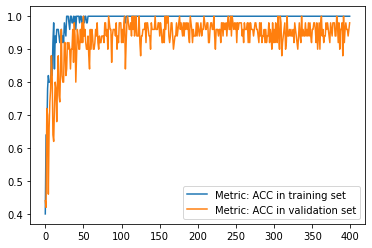

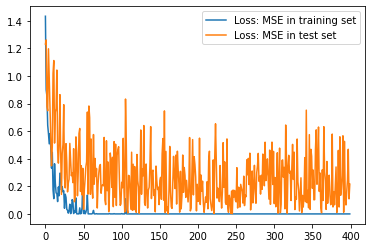

Best epoch:  51
ACC Validation Best Epoch: 1.0
MSE Validation Best Epoch: 51


In [11]:
loss = history.history['loss']
val_acc = history.history['val_acc']
max_val_acc = max(val_acc)
max_val_acc_epoch= val_acc.index(max(val_acc)) + 1

# Plot history base on Metric 
plt.plot(history.history['acc'], label='Metric: ACC in training set')
plt.plot(history.history['val_acc'], label='Metric: ACC in validation set')
plt.legend()
plt.show()

# Plot history base on Loss
plt.plot(history.history['loss'], label='Loss: MSE in training set')
plt.plot(history.history['val_loss'], label='Loss: MSE in test set')
plt.legend()
plt.show()

print('Best epoch: ', max_val_acc_epoch)
print('ACC Validation Best Epoch:', max_val_acc)
print('MSE Validation Best Epoch:', max_val_acc_epoch)

In [16]:
# Confusion Matrix
y_test = validation_generator.classes
y_pred = model.predict_generator(validation_generator, steps=468)
y_pred = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("\nConfusion Matrix Metrics en el Conjunto de Validacion:\n",cm)
print('Precision: %.7f' % precision_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('Recall: %.7f' % recall_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('F1: %.7f' % f1_score(y_true=y_test, y_pred=y_pred, average='macro'))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



Confusion Matrix Metrics en el Conjunto de Validacion:
 [[147   0   2   1]
 [  1  63   1   0]
 [  5   1  94   3]
 [  1   0   3 146]]
Precision: 0.9630634
Recall: 0.9587964
F1: 0.9608228


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
